In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%ls '/gdrive/My Drive/External Projects/chest/'
BASE_PATH = '/gdrive/My Drive/External Projects/chest/'
local_base_dir = "chest_xray/chest_xray" 

A2_GradCAM.ipynb     A2_TL_Resnet.ipynb  weights/
A2_GradCAM_pp.ipynb  archive.zip


In [3]:
import zipfile as zf  
files = zf.ZipFile(BASE_PATH+"archive.zip", 'r')
files.extractall()
files.close()

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import os
import torch 

image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
    ]),
}

train_ds = ImageFolder(root=os.path.join(local_base_dir,"train"), transform=image_transforms['train'])
test_ds = ImageFolder(root=os.path.join(local_base_dir,"test"), transform=image_transforms['test'])
class_names = train_ds.classes
print(class_names)

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, pin_memory=True)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

['NORMAL', 'PNEUMONIA']


In [5]:
import torch.nn as nn
import torchvision.models as models
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        net = models.resnet18(pretrained=True)
        num_ftrs = net.fc.in_features

        net.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,2),
        )

        net.load_state_dict(torch.load(BASE_PATH+"weights/model_1.pt", map_location=torch.device('cpu')))

        self.layers = nn.Sequential(*(list(net.children())[:-2]))

        self.avgpool = net.avgpool
        self.fc = net.fc

        self.gradients = None

        
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.layers(x)
        h = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.view((-1,512))
        x = self.fc(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.layers(x)

In [6]:
img, _ = next(iter(train_dl))

In [7]:
model = ResNet()

model.eval()

pred = model(img)
print(pred.size())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



torch.Size([32, 2])


In [14]:
# pred[:, 0].mean().backward()

gradients = model.get_activations_gradient().detach().numpy()

activations = model.get_activations(img).detach().numpy()

In [33]:
import numpy as np
grads_2 = gradients**2
grads_3 = gradients**3

eps = 0.0001
aij = grads_2 / (2*grads_2+sum_activations[:,:,None,None]*grads_3+eps)

weights = np.maximum(gradients,0)*aij
weights = np.sum(weights, axis=(1))

In [25]:
sum_activations = np.sum(activations, axis=(2,3))
print(sum_activations.shape, grads_2.shape, activations.shape)

(32, 512) (32, 512, 7, 7) (32, 512, 7, 7)


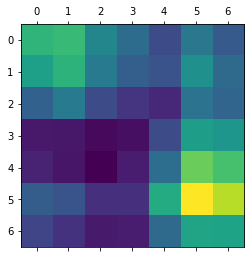

In [36]:
import matplotlib.pyplot as plt

cam = np.zeros((activations.shape[0], *activations.shape[2:]))

for j in range(batch_size):
  for i in range(512):
    cam[j] += activations[j, i, :, :] * weights[j]
    

cam = np.maximum(cam, 0)

cam /= np.max(cam)

plt.matshow(cam[0])

In [38]:
import cv2

for i in range(batch_size):
  heatmap_i = cam[i]
  img_i = np.uint8(img[i].numpy() * 255)
  img_i = np.swapaxes(img_i, 0,2)
  img_i = np.swapaxes(img_i, 0,1)
  heatmap_i = np.uint8(255 * heatmap_i)
  heatmap_i = cv2.resize(heatmap_i, (img_i.shape[1], img_i.shape[0]), interpolation=cv2.INTER_LANCZOS4)
  heatmap_i = cv2.applyColorMap(heatmap_i, cv2.COLORMAP_JET)
  superimposed_img = np.uint8(heatmap_i * 0.4 + img_i * 0.6)
  plt.imshow(superimposed_img)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.